# Determining the delta size

What is the area of the build delta? What determines the delta?

Determining the delta based on a method by John Shaw in: 
https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2008GL033963

Fine tuned by Camu in this notebook.

Based on a visual presentation off how many percentage of the open water can you see within a certain distance.

needs to add actual size calculation from the delineation.


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from interactive import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from skimage import measure
from math import atan2, degrees
from math import hypot

plt.ioff()


## 1. Delta visualisation

Import and visualise the data. What delta are we working on?

In [4]:
nc_file = "Mahakam_500/Mahakam/Mahakam_delta_Netcdf/trim-001.nc"

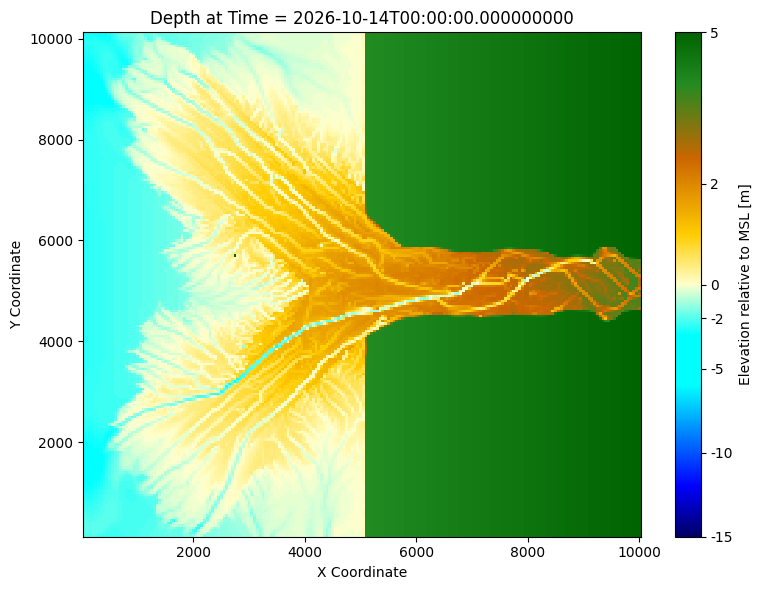

In [5]:
plot_bathymetry_with_colormap(nc_file,vmin=-15,vmax=5)

# 2. Determine delineation

## 2a. Create a binary file

A map with the classification where a pixel is either land (1) or water (0).

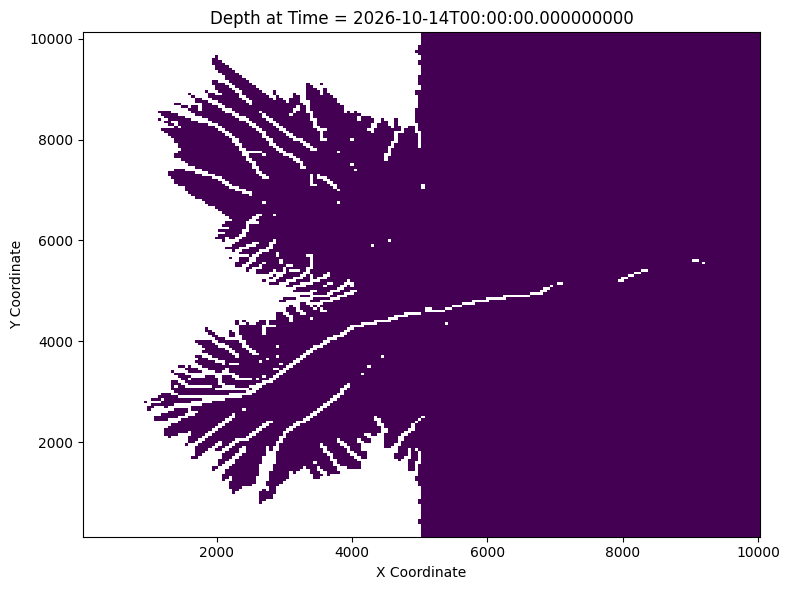

In [7]:
time_index = -1
# vmin = -2.5
# vmax = 5
# vcentre = 0

dataset = xr.open_dataset(nc_file)

# Extract coordinates and depth data
xc = dataset["XCOR"].values[1:-1, 1:-1]
yc = dataset["YCOR"].values[1:-1, 1:-1]
depth = dataset["DPS"]
depth_inner = depth[:, 1:-1, 1:-1] * -1  # Flip sign for elevation

# Time values
time_values = dataset["time"].values
depth_at_t = depth_inner[time_index, :, :]

# land = np.where(depth_at_t >= 0, depth_at_t, np.nan)
landbinary = np.where(depth_at_t >= 0, 1, np.nan)


# Plotting
fig, ax = plt.subplots(figsize=(8, 6))
c = ax.pcolormesh(xc, yc, landbinary)
ax.set_title(f'Depth at Time = {time_values[time_index]}')
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
plt.tight_layout()
plt.show()

In [8]:
# Compute LandWaterInterface: Pixels with one neigbouring water cell
def get_neighbors(shape, x, y):
    neighbors = [(i, j) for i in range(x-1, x+2)
                        for j in range(y-1, y+2)
                        if 0 <= i < shape[0] and 0 <= j < shape[1] and (i, j) != (x, y)]
    return neighbors # 8 location of cells arouond the cell

def get_land_water_interface(binary_raster):           # makes a raster that gives a bool for every pixel that has 1 water next to it 
    lwi = np.zeros_like(binary_raster, dtype=bool)
    land = np.argwhere(binary_raster == 1)             # gets the index of pixels with value 1
    for x, y in land:
        for i, j in get_neighbors(binary_raster.shape, x, y):
            if binary_raster[i, j] == 0:
                lwi[x, y] = True
                break
    return lwi


In [9]:
def get_neighbors(shape, x, y):
    neighbors = [(i, j) for i in range(x-1, x+2)
                        for j in range(y-1, y+2)
                        if 0 <= i < shape[0] and 0 <= j < shape[1] and (i, j) != (x, y)]
    return neighbors

def get_land_water_interface(binary_raster):
    lwi = np.zeros_like(binary_raster, dtype=bool)
    land = np.argwhere(binary_raster == 1)
    for x, y in land:
        for i, j in get_neighbors(binary_raster.shape, x, y):
            if binary_raster[i, j] == 0:
                lwi[x, y] = True
                break
    return lwi

def compute_opening_angle_map(binary_raster, lwi_mask, p=3, max_dist=30):
    theta_map = np.zeros_like(binary_raster, dtype=float)
    
    land_coords = np.argwhere(lwi_mask | (binary_raster == 1))
    test_set = [tuple(pt) for pt in land_coords]
    
    query_coords = np.argwhere((binary_raster == 0) & (~lwi_mask))
    
    count = 0
    for xi, yi in query_coords:
        count += 1
        if count % 2000 == 0:
            print(count)

        angles = []
        for xj, yj in test_set:
            dx, dy = xj - xi, yj - yi
            distance = hypot(dx, dy)
            if distance <= max_dist:
                angle = degrees(atan2(dy, dx)) % 360
                angles.append(angle)
        
        if len(angles) < 2:
            theta_map[xi, yi] = 180
            continue
        
        angles = sorted(angles)
        gaps = [(angles[(i+1) % len(angles)] - angles[i]) % 360 for i in range(len(angles))]
        largest_gaps = sorted(gaps, reverse=True)[:p]
        theta_map[xi, yi] = sum(largest_gaps)

    theta_map[binary_raster == 1] = 0
    return theta_map


def extract_shoreline(theta_map, theta_c=90, blur_sigma=1):
    binary = theta_map > theta_c
    blurred = gaussian_filter(binary.astype(float), sigma=blur_sigma)   # what does this meann
    contours = measure.find_contours(blurred, 0.5)
    return contours

def calculate_contour_area(contour):
    """
    Calculates the signed area of a polygon using the shoelace formula.
    Assumes contour is a Nx2 array of (row, col) = (y, x) coordinates.
    """
    x = contour[:, 1]
    y = contour[:, 0]
    return 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))

# Determine viewing angle

Here I varyt the angle that a pixel of land has to 'see' of the open ocean. I vary between 45, 90 and 120 degrees

In [11]:
raster = np.where(depth_at_t >= 0, 1, 0)
lwi_mask = get_land_water_interface(raster)
theta_map = compute_opening_angle_map(raster, lwi_mask, p=3)

contours90 = extract_shoreline(theta_map, theta_c=90, blur_sigma=1.5)
contours120 = extract_shoreline(theta_map, theta_c=120, blur_sigma=1.5)
contours45 = extract_shoreline(theta_map, theta_c=45, blur_sigma=1.5)

2000
4000
6000
8000
10000


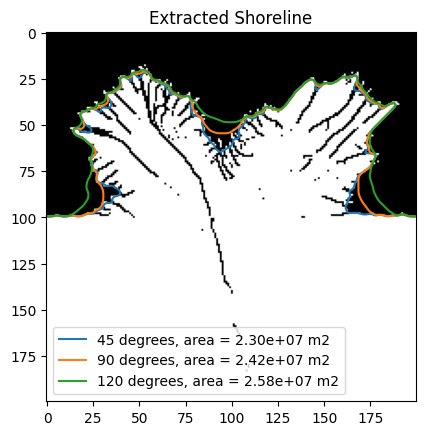

In [12]:
# Plot result
plt.imshow(raster, cmap='gray')

pixel_size = 50 # meters

area45 = calculate_contour_area(contours45[0]) * pixel_size**2
area90 = calculate_contour_area(contours90[0]) * pixel_size**2
area120 = calculate_contour_area(contours120[0]) * pixel_size**2


for contour in contours45:
    plt.plot(contour[:, 1], contour[:, 0], label = f'45 degrees, area = {area45:.2e} m2')
for contour in contours90:
    plt.plot(contour[:, 1], contour[:, 0], label = f'90 degrees, area = {area90:.2e} m2')
for contour in contours120:
    plt.plot(contour[:, 1], contour[:, 0], label = f'120 degrees, area = {area120:.2e} m2')
plt.legend()    
plt.title("Extracted Shoreline")
plt.show()

## 2.b Discuss results

Based on this graph the 45 degrees is choosen. As it illustates best what is the delta. 

## 2. c. Determine blur factor

In [15]:
raster = np.where(depth_at_t >= 0, 1, 0)
lwi_mask = get_land_water_interface(raster)
theta_map = compute_opening_angle_map(raster, lwi_mask, p=3)

contours90_b5 = extract_shoreline(theta_map, theta_c=45, blur_sigma=0.5)
controus90_b25 = extract_shoreline(theta_map, theta_c=45, blur_sigma=0.25)
contours90_b1 = extract_shoreline(theta_map, theta_c=45, blur_sigma=1)
contrours90_b0 = extract_shoreline(theta_map, theta_c=45, blur_sigma=0)
contrours90_b15 = extract_shoreline(theta_map, theta_c=45, blur_sigma=1.5)

2000
4000
6000
8000
10000


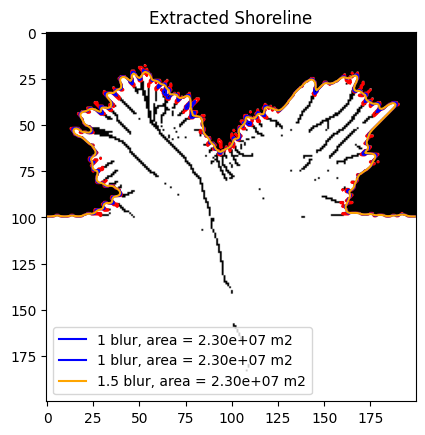

In [16]:
areab5 = calculate_contour_area(contours90_b5[0]) * pixel_size**2
areab1 = calculate_contour_area(contours90_b1[0]) * pixel_size**2
areab15 = calculate_contour_area(contrours90_b15[0]) * pixel_size**2

# Plot result
plt.imshow(raster, cmap='gray')
for contour in contours90_b5:
    plt.plot(contour[:, 1], contour[:, 0], color='red')
for contour in contours90_b1:
    plt.plot(contour[:, 1], contour[:, 0], color='blue', label= f'1 blur, area = {areab1:.2e} m2')
for contour in contrours90_b15:
    plt.plot(contour[:, 1], contour[:, 0], color='orange', label= f'1.5 blur, area = {areab15:.2e} m2')
plt.title("Extracted Shoreline")
plt.legend()
plt.show()
# plt.savefig('')

In [17]:
# What does blur do?

In [18]:
# And what is realistic

___

In [20]:
# work flow for area calc:
# Just make a function for when you know it. 